### Exercise 1

Let $\theta_1$ and $\theta_2$ be real valued parameters of the model

$$
y = \frac{\theta_1 x}{\theta_2 + x}.
$$

a. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$  and use HMC algorithm to find their posterior distributions, conditioning on the observations

$$
x=(28,55,110,138,225,375)\\
y=(0.053,0.060,0.112,0.105,0.099,0.122).
$$

b. Discuss how different parameters for both priors and the HMC algorithm lead to different estimates. 

c. Plot the most reliable posterior distributions, according to convergence checks on the traces.

In [96]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
pyro.set_rng_seed(42)


def my_model(prior1: dist, prior2: dist, x):
        
    theta1 = pyro.sample('theta1', prior1)
    theta2= pyro.sample('theta2', prior2)
    
    y = pyro.param('y',  theta1*x/(theta2+x))
    return y

# measurement observations
obs_x = torch.tensor([28,55,110,138,225,375])
obs_y = torch.tensor([0.053,0.060,0.112,0.105,0.099,0.122])
cond_model = pyro.condition(my_model, data={'y': obs_y, 'x': obs_x})

In [171]:
hmc_kernel = NUTS(model = cond_model)
mcmc = MCMC(hmc_kernel, num_samples=300, warmup_steps=500, num_chains=3)

mcmc.run(dist.Exponential(15), dist.Exponential(2), obs_x)

In [214]:
mcmc.summary()
mcmc.diagnostics()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      0.07      0.06      0.04      0.00      0.15    567.38      1.00
    theta2      0.49      0.46      0.35      0.00      1.14    398.36      1.00

Number of divergences: 0


{'theta1': OrderedDict([('n_eff', tensor(567.3843)),
              ('r_hat', tensor(0.9983))]),
 'theta2': OrderedDict([('n_eff', tensor(398.3558)),
              ('r_hat', tensor(0.9994))]),
 'divergences': {'chain 0': [], 'chain 1': [], 'chain 2': []},
 'acceptance rate': {'chain 0': 0.9733333333333334,
  'chain 1': 0.9766666666666667,
  'chain 2': 0.9966666666666667}}

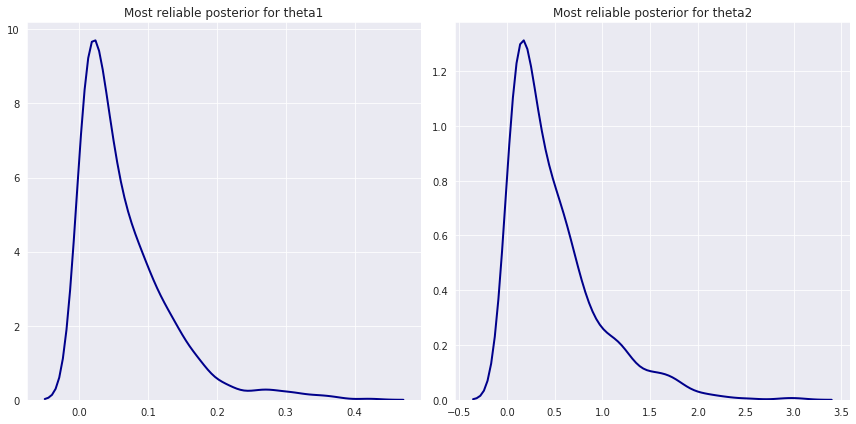

In [173]:
posterior = mcmc.get_samples()
trace1 = posterior["theta1"]
trace2 = posterior["theta2"]

trace=[trace1,trace2]

sns.set_style("darkgrid")
fig, ax = plt.subplots(1,2,figsize=(12,6))

for j in range(2):
    transition_trace = trace[j]
    sns.distplot(transition_trace, hist=False, kde_kws={"lw": 2}, ax=ax[j],color="darkblue")
    plt.tight_layout()
    ax[j].set_title("Most reliable posterior for theta" + str(j+1))

b) I have chosen to use the same functional forms as priors for $\theta_1$ and $\theta_2$ 

- uniform distribution in different positive domains: none of the parameters converged (n_eff $\approx$ 300 for warmup = 1000 and samples= 500, r_hat= 1.01 for both parameters). The posterior distribution of the parameters, it had a very broad distribution which resembles Normal's tails, but was flat (with oscillation) instead of having a peak. Here the number of warmup samples made the flat region smaller, so probably with a very high number of warmups, I could get convergence. The maximum warmup tried is warmup = 5000 for U([0,1])

- Normal Distribution: the posterior is peaked (not sharply) around a mean, which was equal to the mean chosen for the prior of the corresponding parameter. r_hat = 1.00 but n_eff very little.

- Exponential Distribution: again, the posterior is very similar to the prior. r_hat=1 but n_eff is significantly greater than in previous cases.

For all priors functional form, the peak of the posterior is strongly dependent by the prior parameters. That's the reason the posterior found cannot be considered trustworthy. Other distributions were tried (LogNormal) but the best convergence (in term of n_eff and r_hat) was achieved by the Exponential

### Exercise 2

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:
- choose a starting value $p(x_1|x_2^{(0)})$
- for each iteration $i$:
    - draw $x_2(i)$ from $p(x_2|x_1^{(i-1)})$
    - draw $x_1(i)$ from $p(x_1|x_2^{(i)})$

a. Supposing that samples are drawn from a bivariate normal distribution

$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
    implement a Gibbs sampler for $x$ which takes as inputs the number of iterations `iters` and the number of warmup draws `warmup`.

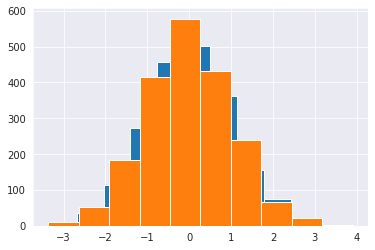

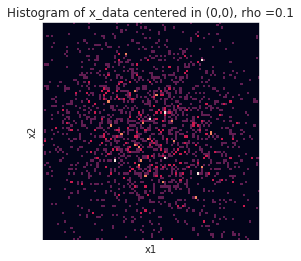

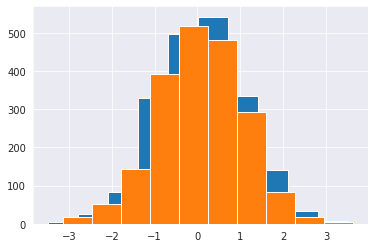

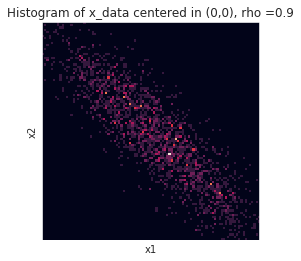

In [203]:
def new_mu(idx, mu, rho, x_other):
    return mu[idx] + rho * (x_other - mu[(idx + 1) % 2])

def gibbs_sampler(guess: float, iters: int, warmup: int, rho: float, mu = [0,0]):
    
    x = [0.,guess]
                           #p(x1|x2)
    x[0] = pyro.sample('x10',dist.Normal(new_mu(0,mu,rho,x[1]), np.sqrt(1-rho**2)))
                     
    for i in range(warmup):
        x[1] = pyro.sample('x2',dist.Normal(new_mu(1,mu,rho,x[0]), np.sqrt(1-rho**2)))
        x[0] = pyro.sample('x10',dist.Normal(new_mu(0,mu,rho,x[1]), np.sqrt(1-rho**2)))
    
    x2_list=[]
    x1_list=[]
    for i in range(iters):
        x[1] = pyro.sample('x2',dist.Normal(new_mu(1,mu,rho,x[0]), np.sqrt(1-rho**2)))
        x[0] = pyro.sample('x10',dist.Normal(new_mu(0,mu,rho,x[1]), np.sqrt(1-rho**2)))
        x2_list.append(x[1])
        x1_list.append(x[0])
    return (x1_list, x2_list)

for rho in [0.1,0.9]:
    x1,x2 = gibbs_sampler(0.1, 2000, 1000, rho)

    plt.hist(x1)
    plt.hist(x2)
    plt.show()

    heatmap, xedges, yedges = np.histogram2d(x1, x2, bins=100, range=((-2,2),(-2,2)))
    plt.clf()
    plt.title('Histogram of x_data centered in (0,0), rho =' + str(rho))
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.xticks(())
    plt.yticks(())
    plt.imshow(heatmap)
    plt.show()

b. Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from **Exercise 1**.

## Parameter estimation

In [220]:
t1_sample = mcmc.get_samples()['theta1']
t2_sample = mcmc.get_samples()['theta2']

mu = [float(t1_sample.mean()), float(t2_sample.mean())]
print("Mean vector: " + str(mu))

t1_sample = np.array(t1_sample)
t2_sample = np.array(t2_sample)

sigma = np.corrcoef(np.array([t1_sample,t2_sample]))
print("Covariance matrix flattened:")
print(sigma.flatten())

estimated_rho = sigma[0,1]

Mean vector: [0.0651819184422493, 0.49141475558280945]
Covariance matrix flattened:
[1.         0.01223405 0.01223405 1.        ]


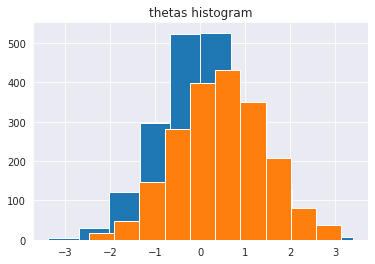

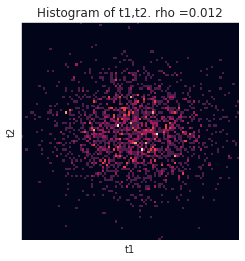

In [287]:
t1_g, t2_g = gibbs_sampler(0.1, 2000, 1000, estimated_rho, mu)
plt.hist(t1_g)
plt.hist(t2_g)
plt.title("thetas histogram")
plt.show()

edges = [[float(min(t1_g)),float(max(t1_g))], [float(min(t2_g)),float(max(t2_g))]]

heatmap, xedges, yedges = np.histogram2d(t1_g, t2_g, bins=100, range = edges)
plt.title('Histogram of t1,t2. rho =' + str(round(estimated_rho,3)))
plt.ylabel('t2')
plt.xlabel('t1')
plt.imshow(heatmap)
plt.xticks(())
plt.yticks(())
plt.show()